# Data Overview 

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data

All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Number of rows in Train.csv = 6034195




Data Field Explaination:

The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')


## Example Data point 

Title:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
Body : 

        #include<
        iostream>\n
        #include<
        stdlib.h>\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout<<"Enter the number of variables";\n         cin>>n;\n\n         
                 cout<<"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y<n+1; y++)\n         
                 {\n                 
                    cin>>m[y];\n                 
                    cin>>u[y];\n         
                 }\n         
                 for(x=1; x<n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1<n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i<n+1; i++)\n         
                 {\n            
                    for(int l=1; l<=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout<<a[l]<<"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j<4; j++)\n            
                    {\n                
                        cout<<e[i][j];\n                
                        for(int k=0; k<n-(i+1); k++)\n                
                        {\n                    
                            cout<<a[k]<<"\\t";\n               
                        }\n                
                        cout<<"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        
\n\n
    <p>The answer should come in the form of a table like</p>\n\n
    <pre><code>       
    1            50              50\n       
    2            50              50\n       
    99           50              50\n       
    100          50              50\n       
    50           1               50\n       
    50           2               50\n       
    50           99              50\n       
    50           100             50\n       
    50           50              1\n       
    50           50              2\n       
    50           50              99\n       
    50           50              100\n
    </code></pre>\n\n
    <p>if the no of inputs is 3 and their ranges are\n
    1,100\n
    1,100\n
    1,100\n
    (could be varied too)</p>\n\n
    <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'

Tags : 'c++ c'

# It's Multi-label Classification problem.

### Performance Metric:

- In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.
- I have been tried ( Micro f1 score - Macro f1 score) This is a better metrics when we have class imbalance.

### Loss Function:

- Hamming Loss.

# Import Liberaries.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from itertools import combinations
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
om sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import make_scorer, f1_score, precision_score,recall_score
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Data Loading and Cleaning using SqLite with pandas 

In [2]:
# Create db File from csv file.
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id','Title','Body','Tags'], chunksize= chunksize , iterator=True, encoding='utf-8'):
        df.index += index_start
        j += 1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

# Count the numbers of rows

In [3]:
if os.path.isfile('train.db'):

    conn = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", conn)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    conn.close()
    
else:
    print("Please download the data.db file from drive or run the above cell to genarate data.db file")

Number of rows in the database : 
 6034196


# Check for  duplicates if exit

In [4]:
if os.path.isfile('data.db'):
    
    conn = sqlite3.connect('data.db')
    df = pd.read_sql_query('SELECT Title, Body, Tags FROM data', conn)
    conn.close()
    duplicates = df.duplicated()

    # Count the number of duplicates
    num_duplicates = duplicates.sum()
    
    print(f"Number of duplicate rows: {num_duplicates}")
    # drop duplicates
    df_no_dup = df.drop_duplicates(subset=['Title', 'Body', 'Tags'])

else:
    print("Please download the train.db file from drive or run the first to generate train.db file")


Number of duplicate rows: 1827881


In [5]:
df_no_dup.head()

,Title,Body,Tags
0,Title,Body,Tags
1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding


In [7]:
# Before Adding a new feature number of tags per question
#First i should handel the missing values befor aplling (split) dunction 

df_no_dup['Tags'] = df_no_dup['Tags'].fillna('')

df_no_dup["count_tag"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
df_no_dup.head()

,Title,Body,Tags,count_tag
0,Title,Body,Tags,1
1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3


In [8]:
df_no_dup.count_tag.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: count_tag, dtype: int64

# Save our data with no duplicate 

In [9]:
if not os.path.isfile("data_no_dup.db"):
    create_disk = create_engine("sqlite:///data_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Titile', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',create_disk)

# Let's make Anlysis for tags  

- Count the number of times each tag appears.
- Visualize the frequency of top tags.
- Analyze tag co-occurrence.

In [10]:
if os.path.isfile('data_no_dup.db'):
    conn = sqlite3.connect('data_no_dup.db')
    tags = pd.read_sql_query('SELECT Tags FROM no_dup_train', conn)
    conn.close()
    
    #Drop unwanted coulmn 
    tags.drop(tags.index[0], inplace=True)
    tags.head()

else:
    print("please download the data with no duplicate ")                    

In [11]:
# Count the number of times each tag appears
# will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tags['Tags'])
df_no_dup['Tags'] = df_no_dup['Tags'].fillna('')
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


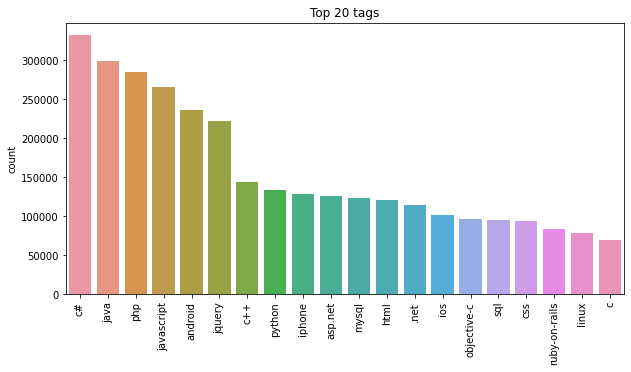

In [24]:
counts = pd.DataFrame(tag_dtm.sum(axis=0), columns=list(vectorizer.get_feature_names_out())) \
           .transpose() \
           .rename(columns={0: 'count'}) \
           .sort_values('count', ascending=False)

# Visualize the frequency of top (20) tags.
top_tags = counts.head(20)
plt.figure(figsize=(10,5))
sns.barplot(x= top_tags.index,y =top_tags['count'])
plt.title('Top 20 tags')
plt.xticks(rotation=90)
plt.show()

# Observations:

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

In [13]:
df_no_dup['Tags'] = df_no_dup['Tags'].fillna('')

In [18]:
# 3. Analyze tag co-occurrence.
# This will count the number of times each pair of tags appears together
counter = Counter()

for tags in df_no_dup['Tags']:
    for subset in combinations(set(tags.split()), 2):
        counter.update(tuple(sorted(subset)))

co_occurrences = pd.DataFrame(counter.items(), columns=['tags', 'count'])
co_occurrences = co_occurrences.sort_values('count', ascending=False)

print(co_occurrences)

                         tags   count
10                         c#  770643
84                       java  679447
2                         php  590962
19                 javascript  582992
97                     jquery  470198
...                       ...     ...
41295                  ctrl-c       1
39676                  pebble       1
31672              virtual-cd       1
22602  reportingservices-2000       1
41977      angularjs-resource       1

[41978 rows x 2 columns]


# Tags per question

1. Show the distribution of the number of tags per question.
2. Analyze and visualize the most common tag pairs.
3. Use a boxplot to show the variation in the number of tags per question.
4. Most Frequent Tags using WordCloud.

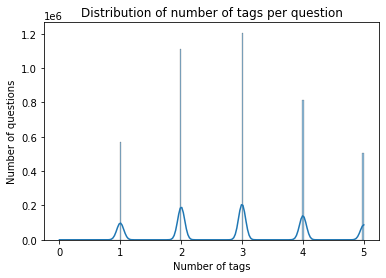

In [23]:
df_no_dup['Num_Tags'] = df_no_dup['Tags'].apply(lambda x: len(x.split()))

# 1. Show the distribution of the number of tags per question.
sns.histplot(df_no_dup['Num_Tags'], kde=True)
plt.title('Distribution of number of tags per question')
plt.xlabel('Number of tags')
plt.ylabel('Number of questions')
plt.show()

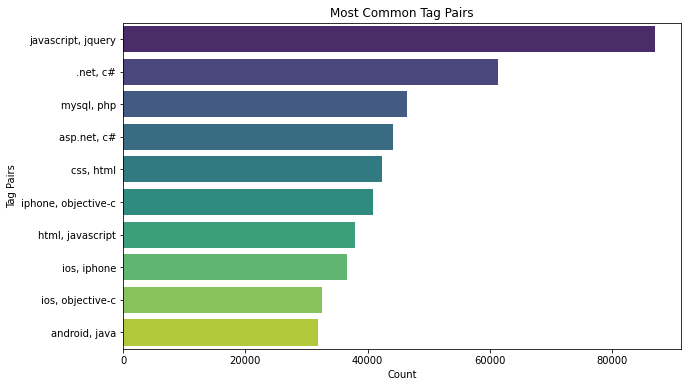

In [25]:
tag_combinations = Counter()

for tags in df_no_dup['Tags']:
    tags = tags.split()
    # get all combinations of tag pairs
    for subset in combinations(set(tags), 2):
        tag_combinations[tuple(sorted(subset))] += 1

# get the 10 most common tag pairs
common_tag_pairs = tag_combinations.most_common(10)

tag_pairs = [f'{i[0][0]}, {i[0][1]}' for i in common_tag_pairs]  # Using f-strings to concatenate the tag pairs into a single string
counts = [i[1] for i in common_tag_pairs]

# Create the DataFrame
df = pd.DataFrame(list(zip(tag_pairs, counts)), columns=['tag_pairs', 'counts'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='tag_pairs', data=df, palette='viridis')
plt.title('Most Common Tag Pairs')
plt.xlabel('Count')
plt.ylabel('Tag Pairs')
plt.show()

# Observation .

1. Dominant Tag Pairs: The most common tags are 'javascript' & 'jquery', '.net' & 'c#', 'mysql' & 'php'. This could indicate that these technologies are frequently used together, or the problems in one often require knowledge in the other.

2. Language and Framework Correspondence: The pairs like 'javascript' & 'jquery', '.net' & 'c#', 'mysql' & 'php' also indicate that certain programming languages are commonly discussed in the context of their respective frameworks or related technologies.

3. Platform Specificity: Pairs like 'ios' & 'iphone', 'android' & 'java', 'ios' & 'objective-c' suggest that questions regarding certain platforms (e.g. iOS, Android) often necessitate specifying the language or the device for a more focused discussion.

4. Web Development: The pair 'html' & 'javascript', 'css' & 'html' indicate a significant amount of web development-related discussions on StackOverflow, as these technologies form the backbone of web development.

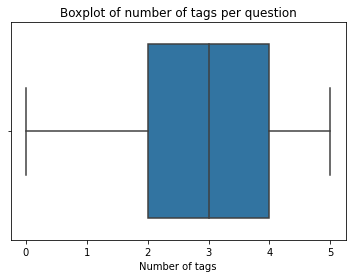

In [26]:
# Use a boxplot to show the variation in the number of tags per question
sns.boxplot(x=df_no_dup['Num_Tags'])
plt.title('Boxplot of number of tags per question')
plt.xlabel('Number of tags')
plt.show()


In [ ]:
# 4. Most Frequent Tags using WordCloud
from wordcloud import WordCloud

tag_data = " ".join(tag for tag in df_no_dup['Tags'])
wordcloud = WordCloud(background_color="white").generate(tag_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Tags')
plt.show()

# Questions Preprocessing
1. I have 4 million question i will use only 0.5 million as a sample.
2.  Separate out code-snippets from Body
3. Remove Spcial characters from Question title and description (not in code).
4. Remove stop words (Except 'C').
5. Remove HTML Tags.
6. Convert all the characters into small letters.
7. Use SnowballStemmer to stem the words .

#### Repate Title Three Times to increase performance but i need to take a small sample for RAM Memory Limitization.

In [47]:
# Take a sample of the data
df_sample = df_no_dup.sample(n=500000, random_state=1)

In [49]:
nltk.download('stopwords')

# set English stopwords
stop_words = set(stopwords.words('english'))

# exclude 'c' from stopwords
if 'c' in stop_words:
    stop_words.remove('c')
#  SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to C:\Users\Mostafa.DESKTOP-
[nltk_data]     RG9643T\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
#function to separate code from the body
def separate_code(text):
    lines = text.split('\n')
    code = []
    non_code = []
    code_flag = False
    for line in lines:
        stripped = line.strip()
        if stripped == '':
            code_flag = not code_flag
            continue
        (code if code_flag else non_code).append(stripped)
    return '\n'.join(non_code), '\n'.join(code)

In [51]:
# Function to clean the text
def clean_text(text):
    stemmer = SnowballStemmer("english")
    stop_words = set(stopwords.words('english'))

    # exclude 'c' from stopwords
    if 'c' in stop_words:
        stop_words.remove('c')
        
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in stop_words)
    return text

In [53]:
clean_questions = []
codes = []

# Process each question
for text in df_sample['Body']:
    text, code = separate_code(text)
    text = clean_text(text)
    clean_questions.append(text)
    codes.append(code)

df_sample['Body'] = clean_questions
df_sample['Code'] = codes

# cleaning process for the 'Title' column
df_sample['Title'] = df_sample['Title'].apply(clean_text)

# Combine 'Title' and 'Body' into a  'questions' column
df_sample['questions'] = df_sample['Title'] + ' ' + df_sample['Title'] +' '+ df_sample['Title'] + ' ' + df_sample['Body']

df_sample = df_sample.drop(['Title', 'Body'], axis=1)

df_sample.head()


,Tags,count_tag,Num_Tags,Code,questions
1295286,testing caching load-testing,3,3,<p>Putting this out there to see how other peo...,test method use privat brows test site without...
4532524,powershell powershell-provider,2,2,<p>The InitializeDefaultDrives method is calle...,powershel initializedefaultdr powershel initia...
996498,wpf mvvm wpf-controls,3,3,"<pre><code>&lt;DataGrid ItemsSource=""{Binding ...",add autocompletebox datagrid add autocompleteb...
2742797,php debugging zend-framework php5 doctrine,5,5,<pre><code>protected function _initDoctrine()\...,init ldap connect like doctrin connect bootstr...
1928849,iphone uinavigationcontroller uinavigationbar ...,4,4,<p>I am almost looking a day at this!</p>\n<pr...,tintcolor uisegmentedcontrol doesnt react tint...


In [55]:
if not os.path.isfile('final_data.db'):
    disk = create_engine("sqlite:///final_data.db")
    no_dup = pd.DataFrame(df_sample, columns=['questions', 'Code', 'Tags'])
    no_dup.to_sql('final',disk)

# Machine Learning part

In [2]:
if os.path.isfile('final_data.db'):
    
    conn = sqlite3.connect('final_data.db')
    df = pd.read_sql_query('SELECT questions, Code, Tags FROM final', conn)
    conn.close()
    
df.head()

,questions,Code,Tags
0,test method use privat brows test site without...,<p>Putting this out there to see how other peo...,testing caching load-testing
1,powershel initializedefaultdr powershel initia...,<p>The InitializeDefaultDrives method is calle...,powershell powershell-provider
2,add autocompletebox datagrid add autocompleteb...,"<pre><code>&lt;DataGrid ItemsSource=""{Binding ...",wpf mvvm wpf-controls
3,init ldap connect like doctrin connect bootstr...,<pre><code>protected function _initDoctrine()\...,php debugging zend-framework php5 doctrine
4,tintcolor uisegmentedcontrol doesnt react tint...,<p>I am almost looking a day at this!</p>\n<pr...,iphone uinavigationcontroller uinavigationbar ...


In [10]:
df.Tags.count()

500000

In [3]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y = vectorizer.fit_transform(df['Tags'])

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['questions'], y, test_size=0.2, random_state=42)

print("Number of data points in train data :", x_train.shape)
print("Number of data points in test data :", x_test.shape)
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000,)
Number of data points in test data : (100000,)
Number of data points in train data : (400000, 30673)
Number of data points in test data : (100000, 30673)


In [6]:
# Tfidf
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", 
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))

# Fit and transform the training data
x_train = vectorizer.fit_transform(x_train)

# Transform the testing data
X_test = vectorizer.transform(x_test)

You can try all these algorithms below but it's take long time to run, here only use the first one :

1. OneVsRest (OvR) strategy with Linear-SVC
2. Binary Relevance method with naive Bayes
3. OneVsRest with Logistic Regression
4. Label Powerset method with Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "estimator__C": [0.01, 0.1, 1],
    "estimator__penalty": ["l1", "l2"],
}
lr = LogisticRegression(solver='saga', multi_class='ovr')
clf = OneVsRestClassifier(lr)
grid_search_clf = GridSearchCV(clf, parameters)
grid_search_clf.fit(x_train, y_train)

print("Best parameters:", grid_search_clf.best_params_)


In [ ]:
ovr_logreg = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
ovr_linearsvc = OneVsRestClassifier(LinearSVC())
lp_tree = LabelPowerset(DecisionTreeClassifier())
ovr_linearsgd = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'))

models = [ovr_logreg, ovr_linearsvc, lp_tree, ovr_linearsgd]
model_names = ['Logistic Regression', 'Linear SVC', 'Label Powerset with Decision Tree', 'SGDClassifier']

# Create scorer
f1_scorer = make_scorer(f1_score, average='micro')

# Apply cross validation
for model, name in zip(models, model_names):
    pipeline = make_pipeline(model)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring=f1_scorer)
    print(f"{name} F1 Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")